### Install and Import Dependencies

In [14]:
# Install the necessary packages
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [51]:
# Importing packages

# For loading, processing, and displaying data
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# For evaluating Classifier
from sklearn import metrics
# For Random Upsampling
from sklearn.utils import resample
# For SMOTE and Borderline SMOTE
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

### Load Dataset

In [16]:
# Dataset downloaded from: https://archive.ics.uci.edu/dataset/266/seismic+bumps
# Load in the arff file
arff_file = arff.loadarff('data/seismic-bumps.arff')

# Convert to a pandas dataframe
data = pd.DataFrame(arff_file[0])

### Explore Dataset

In [17]:
# Get shape of dataframe: (rows, columns)
print("Shape of dataframe (rows, columns): ", data.shape)

Shape of dataframe (rows, columns):  (2584, 19)


In [18]:
# Peek into the dataframe
data.sample(5)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
835,b'a',b'b',b'N',13120.0,19.0,-73.0,-81.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1131,b'a',b'a',b'W',33500.0,231.0,48.0,-53.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2266,b'b',b'b',b'N',30810.0,591.0,23.0,-5.0,b'c',1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,200.0,b'0'
1754,b'a',b'a',b'N',5600.0,344.0,-44.0,-1.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1767,b'b',b'a',b'N',5520.0,171.0,-38.0,-8.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


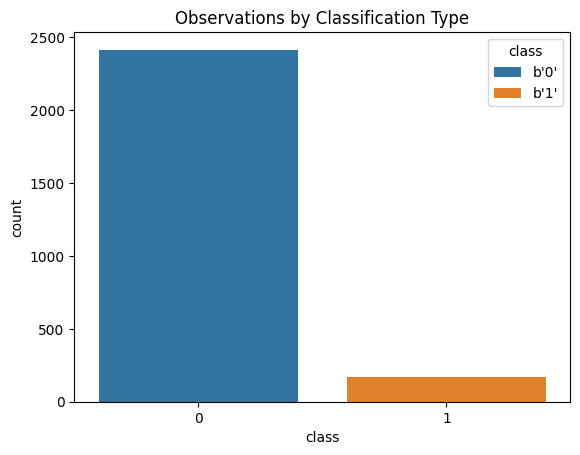

In [19]:
# Seaborn countplot documentation: https://seaborn.pydata.org/generated/seaborn.countplot.html
# Create a bar chart to plot counts of each class
ax = sns.countplot(x = data['class'], hue=data['class'])

# Add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Process/Split Dataset

In [20]:
# Get only the numerical data columns
input_cols = [i for i in range(data.shape[1]) if i not in ([0, 1, 2, 7, 18])]

# Split into input, X, and output, Y
X = data.iloc[:,input_cols]
Y = data.iloc[:,-1].astype(np.float32)

In [21]:
# Get the shape of each
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

# Peak into each part
display(X.head(5))
display(Y.head(5))

Shape of X:  (2584, 14)
Shape of Y:  (2584,)


,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float32

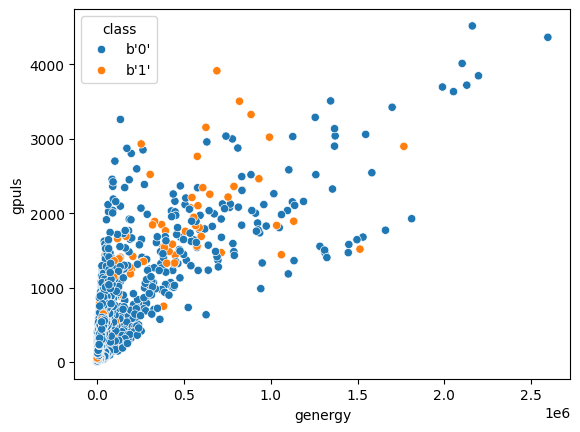

In [22]:
# Plot the some features of the input data with the majority and minority class
# Seaborn Scatterplot documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
ax = sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class')
plt.show()

In [23]:
# Split the data into the train and test set
# Scikitlearn train_test_split documentation: 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Random Forest Scikit-learn

### Baseline Model

In [24]:
# Make the classifier. Use default values except the randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
# Sklearn Random Forest documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
classifier = RandomForestClassifier(random_state=0)

# FIt the classifier to the data
classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

### Evaluation with Performance Metrics

In [25]:
# Running the test set through the model
# This function outputs the probability for each class
baseline_output = classifier.predict_proba(X_test)

# Peek into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(baseline_output[:5])

# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob = baseline_output[:, 1]

[[0.86 0.14]
 [0.98 0.02]
 [1.   0.  ]
 [0.78 0.22]
 [1.   0.  ]]


In [26]:
# Getting the False Positive and True Positive rates for later comparison
# Sklearn roc_curve documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1) # pos_label specifies which class is the positive class

# Finding the AUC score for later comparison
# Sklearn auc documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
baseline_roc_auc = metrics.auc(baseline_fpr, baseline_tpr)

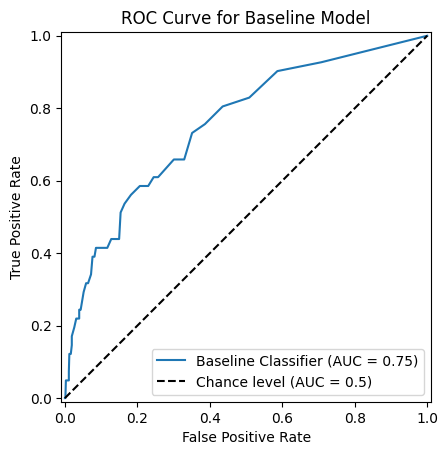

In [27]:
# Plotting the ROC curve
# Sklearn RocCurveDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
baseline_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1, # Specify that class 1 is the positive class
    name='Baseline Classifier', 
    plot_chance_level=True # Plots the ROC curve for a random classifier
)

# Labeling and titling the plot
plt.title("ROC Curve for Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [28]:
# Get precision recall on the test set for later comparison
# Sklearn precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
baseline_precision, baseline_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob)

# Getting the AUC for later comparison
baseline_pr_auc = metrics.auc(baseline_recall, baseline_precision)

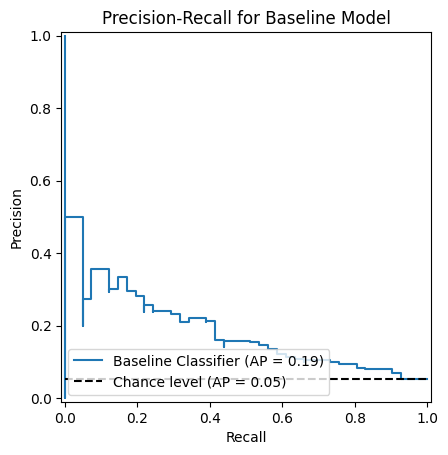

In [29]:
# Plotting the P-R Curve
# Sklearn PrecisionRecallDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
baseline_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Baseline Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampling Techniques

### Random Upsampling

In [30]:
# Get the data for each class
b0_df = X_train[Y_train == 0.0]
b1_df = X_train[Y_train == 1.0]
b0_num_rows = len(b0_df)
b1_num_rows = len(b1_df)

In [31]:
# Displaying ratios of classes
print('Percentage of class 0 training data before random upsampling:', round((b0_num_rows/len(Y_train)) * 100, 2), '%')
print('Percentage of class 1 training data before random upsampling:', round((b1_num_rows/len(Y_train)) * 100, 2), '%')

Percentage of class 0 training data before random upsampling: 92.87 %
Percentage of class 1 training data before random upsampling: 7.13 %


In [32]:
# TODO: USE IMBLEARN
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
# Upsample by randomly sampling the minority class
b1_upsampled_df = resample(b1_df, random_state=42, n_samples=b0_num_rows, replace=True)
b0_upsampled_df = b0_df

In [33]:
b1_upsampled_rows = len(b1_upsampled_df)
b0_upsampled_rows = len(b0_upsampled_df)

In [34]:
X_train_upsampled = pd.concat([b0_upsampled_df, b1_upsampled_df]).reset_index(drop=True)
Y_train_upsampled = pd.concat([pd.Series([0.0 for _ in range(b1_upsampled_rows)]), pd.Series([1.0 for _ in range(b0_upsampled_rows)])]).reset_index(drop=True)
Y_train_upsampled.name='class'

In [35]:
print('Percentage of b0 training data after random upsampling:', round((b0_upsampled_rows/len(X_train_upsampled)) * 100, 2), '%')
print('Percentage of b1 training data after random upsampling:', round((b1_upsampled_rows/len(X_train_upsampled)) * 100, 2), '%')

Percentage of b0 training data after random upsampling: 50.0 %
Percentage of b1 training data after random upsampling: 50.0 %


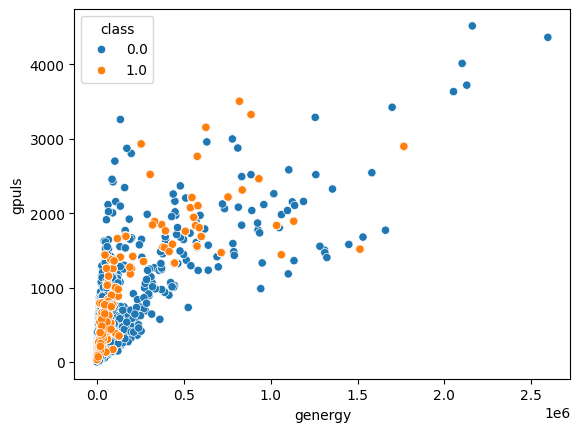

In [36]:
# Put data into dataframe for plotting
df_random_upsampled = pd.concat([X_train_upsampled, Y_train_upsampled], axis=1)

# Plot the data now
ax = sns.scatterplot(df_random_upsampled, x='genergy', y='gpuls', hue='class')
plt.show()

In [37]:
# Make the classifier. 
# Using default values except:
# Max depth of each tree is 2
# The randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
classifier_randomly_upsampled = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier_randomly_upsampled.fit(X_train_upsampled, Y_train_upsampled)

RandomForestClassifier(max_depth=2, random_state=0)

In [38]:
# Running the test set through the model
# This function outputs the probability for each class
upsampled_output = classifier_randomly_upsampled.predict_proba(X_test)
# Peak into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(upsampled_output[:10])
# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob_upsampled = upsampled_output[:, 1]

[[0.64905329 0.35094671]
 [0.64456194 0.35543806]
 [0.64456194 0.35543806]
 [0.30619666 0.69380334]
 [0.78444362 0.21555638]
 [0.60617415 0.39382585]
 [0.39816441 0.60183559]
 [0.4335427  0.5664573 ]
 [0.51221539 0.48778461]
 [0.24304241 0.75695759]]


In [39]:
# Getting the ROC curve and plotting
upsampled_fpr, upsampled_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_upsampled, pos_label=1)

# Finding the AUC score
upsampled_roc_auc = metrics.auc(upsampled_fpr, upsampled_tpr)

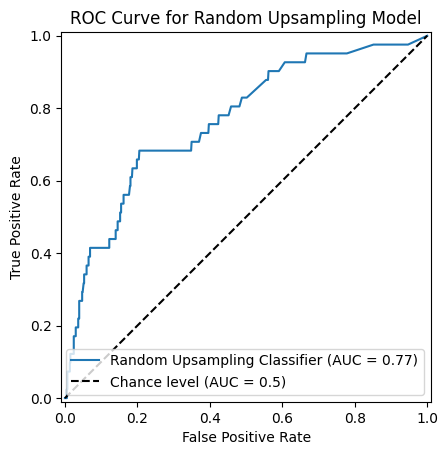

In [40]:
# Plotting the ROC curve
upsampled_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled, 
    pos_label=1,
    name='Random Upsampling Classifier', 
    plot_chance_level=True, # Plots the ROC curve for a random classifier
)

# Labeling and TItling the Plot
plt.title("ROC Curve for Random Upsampling Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [41]:
# Get precision recall on test set
upsampled_precision, upsampled_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_upsampled)

# Getting the AUC
upsampled_pr_auc = metrics.auc(upsampled_recall, upsampled_precision)

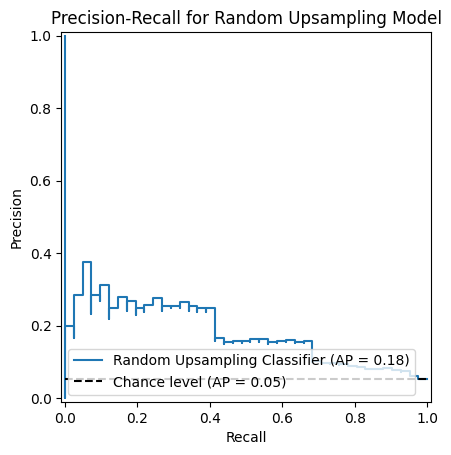

In [42]:
# Plotting the P-R Curve
upsampled_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled,
    pos_label = 1,
    name = "Random Upsampling Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Random Upsampling Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### SMOTE

In [43]:
# Applying SMOTE to the training data
# Imblearn SMOTE documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
X_train_SMOTE, Y_train_SMOTE = SMOTE().fit_resample(X_train, Y_train)

In [44]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_SMOTE)
total = counter[0] + counter[1]
print('After Using SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  129
Class 0:  92.87 %, Class 1:  7.13 %

After Using SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  1679
Class 0:  50.0 %, Class 1:  50.0 %


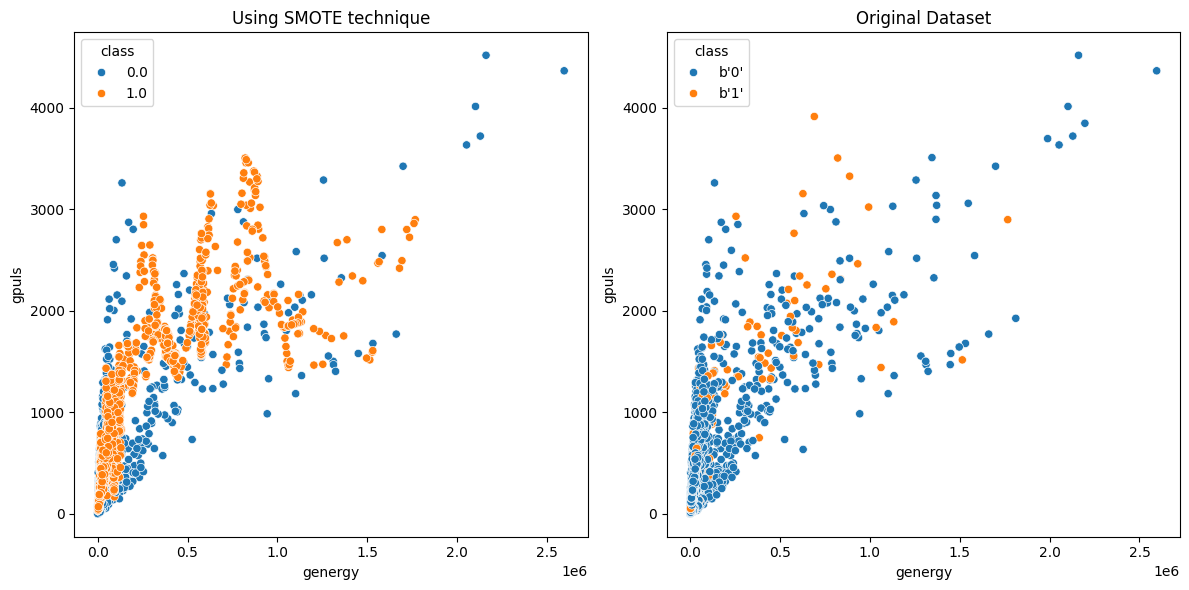

In [45]:
# Plot the new data
SMOTEDf = pd.concat([X_train_SMOTE, Y_train_SMOTE], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=SMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [46]:
# I feel like we should embedded this code in like a drop down to save space because most of it is repeat stuff
# If the user wants to look at it again then sure let them, but at the end we should compare all ROC curves

# Building and fitting the classifier to the SMOTE data
SMOTE_model = RandomForestClassifier(random_state=0)
SMOTE_model.fit(X_train_SMOTE, Y_train_SMOTE)
output = SMOTE_model.predict_proba(X_test)
y_class1_pred_prob_SMOTE = output[:, 1]

In [47]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
SMOTE_fpr, SMOTE_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_SMOTE, pos_label=1)
SMOTE_roc_auc = metrics.auc(SMOTE_fpr, SMOTE_tpr)
SMOTE_precision, SMOTE_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_SMOTE)
SMOTE_pr_auc = metrics.auc(SMOTE_recall, SMOTE_precision)

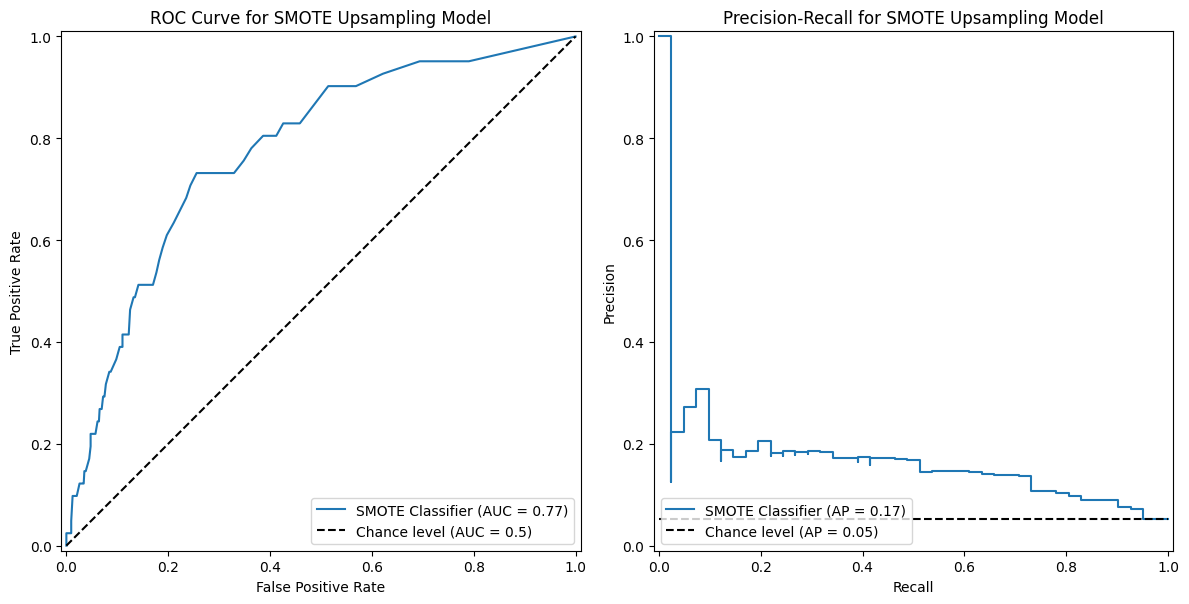

In [48]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE, 
    pos_label=1,
    name='SMOTE Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for SMOTE Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE,
    pos_label = 1,
    name = "SMOTE Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for SMOTE Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### Borderline SMOTE

In [52]:
# Applying SMOTE to the training data
# Imblearn SMOTE documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html
X_train_BordSMOTE, Y_train_BordSMOTE = BorderlineSMOTE().fit_resample(X_train, Y_train)

In [53]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using Borderline SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_BordSMOTE)
total = counter[0] + counter[1]
print('After Using Borderline SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using Borderline SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  129
Class 0:  92.87 %, Class 1:  7.13 %

After Using Borderline SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  1679
Class 0:  50.0 %, Class 1:  50.0 %


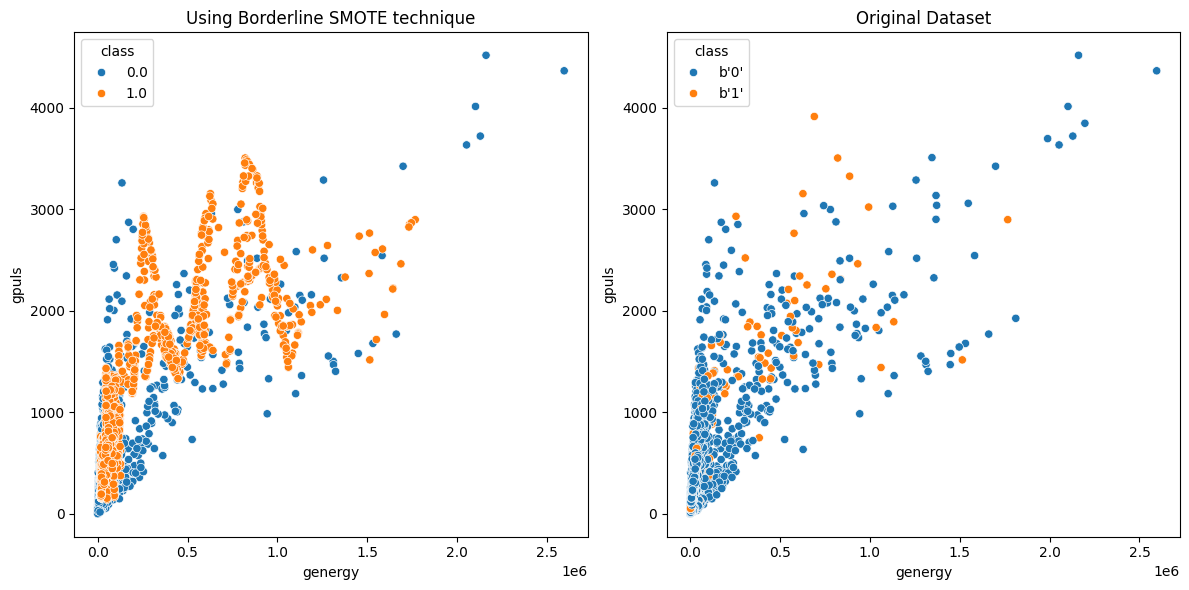

In [54]:
# Plot the new data
BordSMOTEDf = pd.concat([X_train_BordSMOTE, Y_train_BordSMOTE], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=BordSMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using Borderline SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [55]:
# I feel like we should embedded this code in like a drop down to save space because most of it is repeat stuff
# If the user wants to look at it again then sure let them, but at the end we should compare all ROC curves

# Building and fitting the classifier to the SMOTE data
BordSMOTE_model = RandomForestClassifier(random_state=0)
BordSMOTE_model.fit(X_train_BordSMOTE, Y_train_BordSMOTE)
output = BordSMOTE_model.predict_proba(X_test)
y_class1_pred_prob_BordSMOTE = output[:, 1]

In [56]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
BordSMOTE_fpr, BordSMOTE_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_BordSMOTE, pos_label=1)
BordSMOTE_roc_auc = metrics.auc(BordSMOTE_fpr, BordSMOTE_tpr)
BordSMOTE_precision, BordSMOTE_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_BordSMOTE)
BordSMOTE_pr_auc = metrics.auc(BordSMOTE_recall, BordSMOTE_precision)

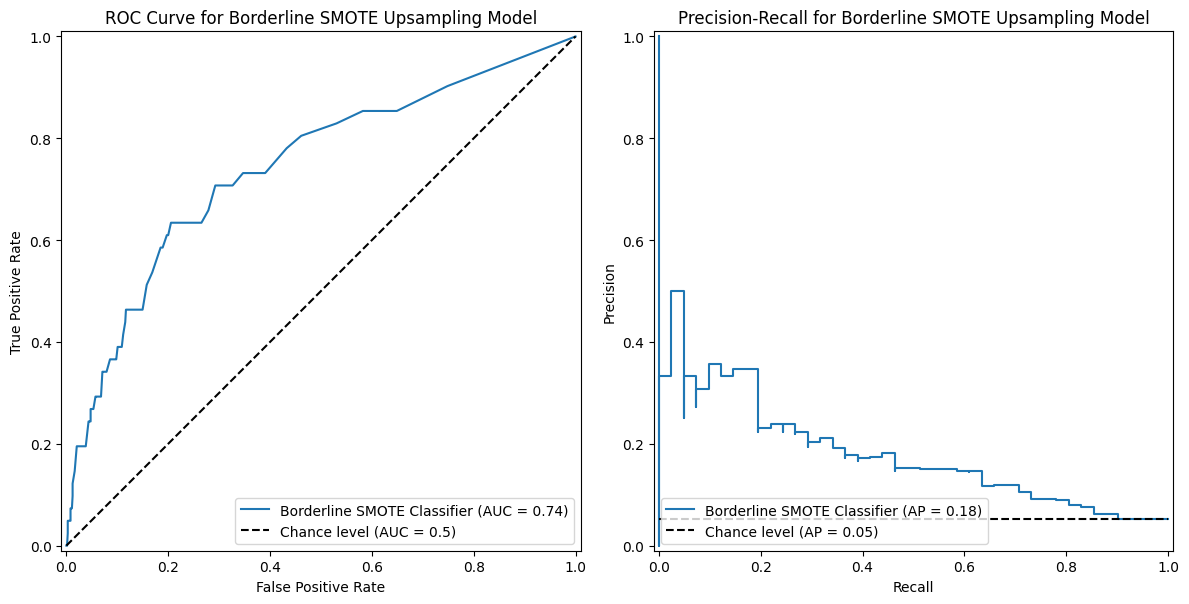

In [57]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE, 
    pos_label=1,
    name='Borderline SMOTE Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Borderline SMOTE Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE,
    pos_label = 1,
    name = "Borderline SMOTE Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Borderline SMOTE Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Comparisons